In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm.auto import tqdm
from utils import *
from setups import uncertainties, methods_config, metrics_config, variable_config, methods_no_pred_estimate, uncertainties_config, metrics_set_up


exp = "ExpA"

In [13]:
simulation_set_up = pd.read_csv(os.path.join("data", exp, "simulation_set_up.csv"))

In [14]:
np.load("data/ExpA/test_data/LOG_n115000_d5_corr00_prcNA05_prop105_rep0.npz")

NpzFile 'data/ExpA/test_data/LOG_n115000_d5_corr00_prcNA05_prop105_rep0.npz' with keys: X_obs, M, y, y_probs, X_full

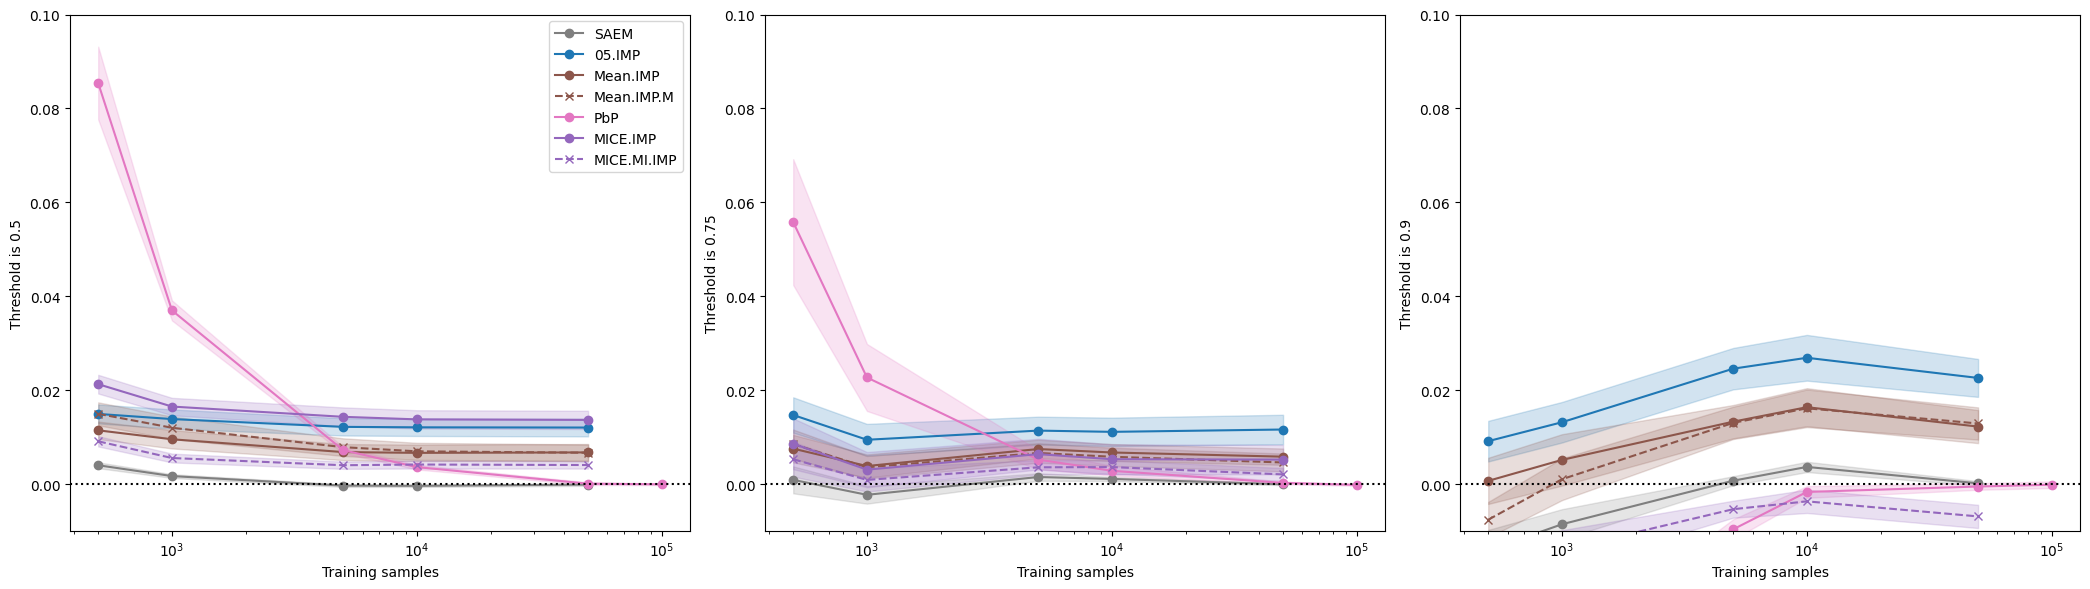

In [18]:
def classification_error_threshold(true, pred, true_y, threshold=0.5):
    preds = (pred > threshold).astype(int)
    return np.mean(preds != true_y)

def plot_one_subplot_pred(
        ax,
        df,
        threshold,
        uncertainty,
        pattern,
        diff_bayes,
):
    all_methods = df["method"].unique()
    all_training_samples = df["n_train"].unique()

    dict_all_scores = {}

    for method in all_methods:
        dict_all_scores[method] = {}
        for n_train in all_training_samples:
            dict_all_scores[method][n_train] = []
            
    for i, row_set_up in df.iterrows():
        method = row_set_up["method"]
        n_train = row_set_up["n_train"]

        if pattern is not None:
            M = np.load(os.path.join("data", exp, "test_data",f"{row_set_up['set_up']}.npz"))["M"]
            idx_pattern = get_index_pattern(pattern, M, remove_all_missing=True)

        pred = np.load(os.path.join("data", exp, "pred_data",f"{row_set_up['file_name']}.npz"))["y_probs_pred"].ravel()
        pred = pred[idx_pattern] if pattern is not None else pred

        true = np.load(os.path.join("data", exp, "test_data",f"{row_set_up['set_up']}.npz"))["y_probs"].ravel()
        true = true[idx_pattern] if pattern is not None else true
        true_y = np.load(os.path.join("data", exp, "test_data",f"{row_set_up['set_up']}.npz"))["y"].ravel()
        true_y = true_y[idx_pattern] if pattern is not None else true_y

        score = classification_error_threshold(true, pred, true_y, threshold)

        if diff_bayes:
            bayes = np.load(os.path.join("data", exp, "bayes_data",f"{row_set_up['set_up']}.npz"))["y_probs_bayes"]
            bayes = bayes[idx_pattern] if pattern is not None else bayes

            score -= classification_error_threshold(true, bayes, true_y, threshold)

        dict_all_scores[method][n_train].append(score)

    dict_mean_scores = {}
    dict_uncertainty_scores = {}
    for method in all_methods:
        dict_mean_scores[method] = {}
        dict_uncertainty_scores[method] = {}
    
        for n_train in all_training_samples:
            if len(dict_all_scores[method][n_train]) == 0:
                dict_mean_scores[method][n_train] = np.nan
                dict_uncertainty_scores[method][n_train] = np.nan
            else:
                dict_mean_scores[method][n_train] = np.mean(dict_all_scores[method][n_train])
                dict_uncertainty_scores[method][n_train] = uncertainties[uncertainty](dict_all_scores[method][n_train])
        
    for method in all_methods:
        
        x = dict_mean_scores[method].keys() #n_train
        y = [dict_mean_scores[method][n_train] for n_train in x]

        yerr = [dict_uncertainty_scores[method][n_train] for n_train in x]
        ax.plot(x, y, label=methods_config[method]["label"], color=methods_config[method]["color"], 
                linestyle=methods_config[method]["linestyle"], marker=methods_config[method]["marker"])
        ax.fill_between(x, np.array(y) - np.array(yerr), np.array(y) + np.array(yerr), alpha=0.2, 
                        color=methods_config[method]["color"])

    return ax



def plot_pred_scores_subplots(
        
        data,

        thresholds = None,
        uncertainty = "se",
        pattern = None,
        diff_bayes = True,

        log_x = True,
        log_y = False,
        min_y = None,
        max_y = None,

        select_methods = None,
        remove_methods = None,
        save = None,

        size_height = 5,
        size_width = 5,

        ##

        **kwargs
):
    
    if thresholds is None:
        thresholds = [0.5, 0.75, 0.9]

    df = filter_data(data, **kwargs)

    methods = df["method"].unique()
    if select_methods is not None:
        methods = [m for m in methods if m in select_methods]
    if remove_methods is not None:
        methods = [m for m in methods if m not in remove_methods]
    methods = [m for m in methods if m not in methods_no_pred_estimate]
    df = df[df["method"].isin(methods)]

    fig, axs = plt.subplots(1, len(thresholds), figsize=(size_width*len(thresholds), size_height))
    if len(thresholds) == 1:
        axs = [axs]

    for i, thr in enumerate(thresholds):

        ax = axs[i]

        plot_one_subplot_pred(ax, df, thr, uncertainty, pattern, diff_bayes)

        ax.set_xlabel("Training samples")
        ax.set_ylabel(f"Threshold is {thr}")
        ax.set_ylim(min_y, max_y)
        if i == 0:
            ax.legend()

        if log_x:
            ax.set_xscale("log")
        if log_y:
            ax.set_yscale("log")
        ax.axhline(0, color="black", linestyle=":")
    

    plt.tight_layout()
    if save is not None:
        plt.savefig(save)

    plt.show()

metric = "brier_score"
remove_methods=["05.IMP.M", "ICE.IMP", "ICE.IMP.M", "ICEY.IMP.M", "ICEY.IMP", "MICE.Y.IMP", "MICE.Y.M.IMP", "MICE.M.IMP"]
select_methods=None 

plot_pred_scores_subplots(
    
    simulation_set_up,
    thresholds=[0.5,0.75,0.9],
    diff_bayes=True,
    pattern=None,

    max_y = 0.10,
    min_y = -0.01,

    remove_methods=remove_methods,
    select_methods=select_methods,

    size_height = 6,
    size_width = 7,

    # save = "data/ExpA/figures/brier_patterns.pdf"
    
)